In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
import math
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [6]:
class MDP():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.v_map = np.full(self.grid_map.shape, 0)    #状態価値関数
        self.pi_map = np.full(self.grid_map.shape, 1)    #各グリッドにおける方策，初期値1＝右方向
        
        for x, grids in enumerate(self.grid_map):
            for y, grid in enumerate(grids):
                if(self.isGoal([x, y])):
                    self.v_map[x][y] = 100    #ゴールの初期価値は高めに設定
                    self.pi_map[x][y] = 0    #ゴールでの方策は「停止」
    
    def draw(self, ax, elems):
        self.sweep()
        self.drawV(ax, elems);
       
    #価値関数更新
    def sweep(self):
        #全てのグリッドで価値を更新する
        for x in range(len(self.grid_map)):
            for y in range(len(self.grid_map[0])):
                s = [x, y]
                a = self.PI(s)
                v = 0
                for s_ in self.listNeigbor(s):
                    v += self.p(s, a, s_) * (self.R(s, a, s_) + self.V(s_))
                self.v_map[x][y] = v        
    
    #状態価値関数描画
    def drawV(self, ax, elems):
        for x in range(len(self.grid_map)):
            for y in range(len(self.grid_map[0])):
                if(self.isObstacle([x, y])):
                    continue
                cost_adj = 4.8    #map1
                #cost_adj = 5    #map2
                c_num = int(-self.v_map[x][y]) + 100
                c_num = int(c_num * cost_adj) #Black→Blue
                if(c_num > 0xff): #Blue → Cyan
                    c_num = (c_num-0xff)*16*16 + 0xff
                    if(c_num > 0xffff): #Cyan → Green
                        c_num = 0xffff - int((c_num-0x100ff)*4/256)
                        if(c_num < 0xff00): #Green →Yellow
                            c_num = (0xff00-c_num)*65536+0xff00
                            if(c_num > 0xffff00): #Yellow → Red
                                c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                c = '#' + format(int(c_num), 'x').zfill(6)
                r = patches.Rectangle(
                    xy=(x*self.world.grid_step[0], y*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color=c,
                    fill=True,
                    alpha=0.7
                )
                elems.append(ax.add_patch(r))
          
    #状態遷移確率
    def p(self, s, a, s_):
        if(s_[0]<0 or s_[0]>self.grid_map.shape[0]-1): #地図の範囲外か（x軸方向）
            return 0.0
        elif(s_[1]<0 or s_[1]>self.grid_map.shape[1]-1):
            return 0.0
        else:
            if(a == 0):
                if(s_[0]-s[0] == 0 and s_[1]-s[1] == 0):
                    return 1.0
                else:
                    return 0.0                
            elif(a == 1):
                if(s_[0]-s[0] == 1 and s_[1]-s[1] == 0):
                    return 1.0
                else:
                    return 0.0
            elif(a == 2):
                if(s_[0]-s[0] == 1 and s_[1]-s[1] == 1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 3):
                if(s_[0]-s[0] == 0 and s_[1]-s[1] == 1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 4):
                if(s_[0]-s[0] == -1 and s_[1]-s[1] == 1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 5):
                if(s_[0]-s[0] == -1 and s_[1]-s[1] == 0):
                    return 1.0
                else:
                    return 0.0
            elif(a == 6):
                if(s_[0]-s[0] == -1 and s_[1]-s[1] == -1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 7):
                if(s_[0]-s[0] == 0 and s_[1]-s[1] == -1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 8):
                if(s_[0]-s[0] == 1 and s_[1]-s[1] == -1):
                    return 1.0
                else:
                    return 0.0
    
    #価値関数
    def R(self, s, a, s_):
        if(s == self.world.goal_index):
            return 0.0
        if(a == 0):
            return -5.0
        return self.moveCost(s, s_) - 1
    
    #移動コスト関数
    def moveCost(self, s, s_):
        return -math.sqrt((s[0]-s_[0])**2+(s[1]-s_[1])**2)
    
    #状態価値関数
    def V(self, s):
        return self.v_map[s[0]][s[1]]
    
    #方策
    def PI(self, s):
        return self.pi_map[s[0]][s[1]]
    
    def isStart(self, s):
        if(self.grid_map[s[0]][s[1]] == '2'):
            return True
        else:
            return False
    
    def isGoal(self, s):
        if(self.grid_map[s[0]][s[1]] == '3'):
            return True
        else:
            return False
     
    def isObstacle(self, s):
        if(self.grid_map[s[0]][s[1]] == '0'):
            return True
        else:
            return False

    def isOutOfBounds(self, s):
        if(s[0]<0 or s[0]>self.grid_map.shape[0]-1):
            return True
        elif(s[1]<0 or s[1]>self.grid_map.shape[1]-1):
            return True
        return False
    
    def listNeigbor(self, s):
        neigbors = []
        for i in range(-1, 2):
            if(s[0]+i<0 or s[0]+i>self.grid_map.shape[0]-1): #地図の範囲外か（x軸方向）
                continue;
            for j in range(-1, 2):
                if(s[1]+j<0 or s[1]+j>self.grid_map.shape[1]-1): #地図の範囲外か（y軸方向）
                    continue
                elif(self.grid_map[s[0]+i][s[1]+j] == '0'): #障害物か
                    continue
                else:
                    neigbors.append([s[0]+i, s[1]+j])
        return neigbors

<IPython.core.display.Javascript object>


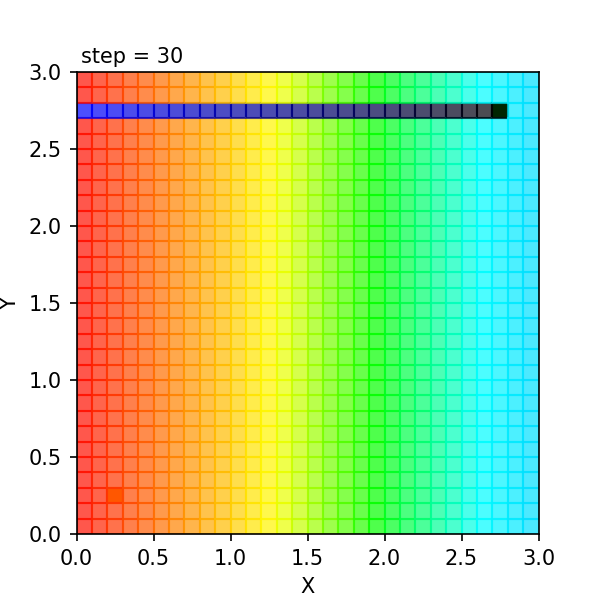

In [7]:
if __name__ == "__main__":
    time_span = 3
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map1.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(MDP(world))
    
    world.draw()
    #world.ani.save('dijkstra_map1.gif', writer='pillow', fps=100)    #アニメーション保存